# Auto Poster Generation
## 当前任务
### 打分器（实际上可看作二分类问题）
#### 1. 输入
- 正样本：已有的海报图像，label为1
- 负样本：在现有海报图像的基础上随机搭配，label为0

#### 2. 网络结构
- 可以用现有的卷积基模型，可能需要fine-tune
- 也可以自己构造一个简单的模型（尝试）
- 对于卷积基提取的特征，后面接上Flatten和Dense层，最后做一个二分类

#### 3. 输出
- 输出的概率值既可以看作是打分器的分数

In [1]:
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

/home/wangh/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
standard_width = 200
standard_height = 280

### 读取数据集并进行预处理

In [3]:
"""Data Aumentation
   1. 翻转变换 flip
   2. 随机修剪 random crop
   3. 色彩抖动 color jittering
   4. 平移变换 shift
   5. 尺度变换 scale
   6. 对比度变换 contrast
   7. 噪声扰动 noise
   8. 旋转变换/反射变换 Rotation/reflection
"""
import matplotlib.pyplot as plt 
from PIL import Image, ImageEnhance, ImageOps, ImageFile
import glob
import numpy as np
import random
import threading, os, time
from multiprocessing import Pool

# import logging
# logger = logging.getLogger(__name__)
# ImageFile.LOAD_TRUNCATED_IMAGES = True

U_NORM_PARAM = 0.435912
V_NORM_PARAM = 0.614777

class ImageProcess:
    """
    Eight ways to augment image data
    """


    def __init__(self):
        pass

    @staticmethod
    def openImage(image):
        return Image.open(image, mode="r")
    
    @staticmethod
    def saveImage(image, path):
        image.save(path)
        
    @staticmethod
    def checkDir(src_path, dst_path):
        if not os.path.isdir(src_path):
            print(src_path, "is not directory!")
            return False
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
            print("make new", dst_path, "path!")   
        return True
    
    @staticmethod
    def getAllFiles(rootDir):
        files = []
        fileList = os.listdir(rootDir) # list all directories and files

        for i in fileList:

            path = os.path.join(rootDir, i)
            if os.path.isdir(path):
                files.extend(ImageProcess.getAllFiles(path))
            elif os.path.isfile(path):
                files.append(path)
        return files

    @staticmethod
    def rgb_to_yuv(image):
        """
        convert image in RGB format to YUV
        :param image PIL class image
        :return: numpy array of image after conversion
        """
        rgb_img = np.array(image)
        _r = rgb_img[:, :, 0]
        _g = rgb_img[:, :, 1]
        _b = rgb_img[:, :, 2]

        _y = 0.299 * _r + 0.587 * _g + 0.114 * _b
        _u = 0.492 * (_b - _y)
        _v = 0.877 * (_r - _y)

        _u = _u / (U_NORM_PARAM * 2) + 0.5
        _v = _v / (V_NORM_PARAM * 2) + 0.5

        # given an interval, values outside the interval are clipped to the interval edges.
        _y = _y.clip(0, 1)
        _u = _u.clip(0, 1)
        _v = _v.clip(0, 1)
        
        # reshape to 3-dimension
        _y = _y.reshape((280, 200, 1))
        _u = _u.reshape((280, 200, 1))
        _v = _v.reshape((280, 200, 1))
        
        # concatenate the vector with the 2nd axis
        yuv_img = np.concatenate((_y, _u, _v), axis=2)

        return yuv_img

    def yuv_to_rgb(image):
        """
        convert image in YUV format to RGB
        :param image PIL class image
        :return: numpy array of image after conversion
        """

        yuv_img = np.array(image)

        _y = yuv_img[:, :, 0]
        _u = yuv_img[:, :, 1]
        _v = yuv_img[:, :, 2]

        _u = (_u - 0.5) * U_NORM_PARAM * 2
        _v = (_v - 0.5) * V_NORM_PARAM * 2

        _r = _y + 1.14 * _v
        _g = _y - 0.395 * _u - 0.581 * _v
        _b = _y + 2.033 * _u

        # given an interval, values outside the interval are clipped to the interval edges.
        _r = _r.clip(0, 1)
        _g = _g.clip(0, 1)
        _b = _b.clip(0, 1)
        
        # reshape to 3-dimension
        _r = _r.reshape((280, 200, 1))
        _g = _g.reshape((280, 200, 1))
        _b = _b.reshape((280, 200, 1))
        
        # concatenate the vector with the 2nd axis
        rgb_img = np.concatenate((_r, _g, _b), axis=2)
        return rgb_img
        
    @staticmethod
    def imageResize(image, height=280, width=200, mode=Image.BICUBIC):
        """
        resize the image to specific size
        :param mode 邻近插值,双线性插值,双三次B样条插值(default)
        :param image PIL class image
        :return: image after resize
        """
        return image.resize((width, height), mode)

    @staticmethod
    def randomRotation(image, mode=Image.BICUBIC):
        """
        rotate image at random angle
        :param mode 邻近插值,双线性插值,双三次B样条插值(default)
        :param image PIL class image
        :return: image after rotation
        """
        random_angle = np.random.randint(-20, 20)
        return image.rotate(random_angle, mode)

    @staticmethod
    def randomCrop(image):
        """
        considering the size of pic (200, 280), use windows ranged from 40 to 70 to crop randomly
        :param image: PIL class image
        :return: image after crop

        """
        image_width = image.size[0]
        image_height = image.size[1]
        crop_win_size = np.random.randint(190, 200)
        random_region = (
            (image_width - crop_win_size) >> 1, 
            (image_height - crop_win_size) >> 1, 
            (image_width + crop_win_size) >> 1,
            (image_height + crop_win_size) >> 1
        )
        image = image.crop(random_region)
        return ImageProcess.imageResize(image)


    @staticmethod
    def randomColor(image):
        """
        use color jittering
        :param image: PIL class image
        :return: image of
        """
        # No restriction to random_factor, 1.0 is origin
        
        # adjust the saturation
        random_factor = np.random.uniform(0.7, 1.6)
        minus = np.random.choice([1, -1])
        random_factor *= minus
        color_image = ImageEnhance.Color(image).enhance(random_factor)  
        
        # adjust the brightness
        random_factor = np.random.uniform(0.6, 1.3) 
        brightness_image = ImageEnhance.Brightness(color_image).enhance(random_factor)  
        
        # adjust the contrastion
        random_factor = np.random.uniform(0.4, 1.8)
        contrast_image = ImageEnhance.Contrast(brightness_image).enhance(random_factor)
        
        # adjust the sharpness
        random_factor = np.random.uniform(0, 2)
        sharpness_image = ImageEnhance.Sharpness(contrast_image).enhance(random_factor)
        
        return sharpness_image

    @staticmethod
    def randomGaussian(image, mean=0.0, stddev=0.3):
        """
        use Gaussian nosiy to process image
        :param image:
        :return:
        """

        def gaussianNoisy(im, mean=0.0, stddev=0.3):
            """
            sub function
            :param im: image in 1 dimension
            :param mean: mean
            :param stddev: stddev
            :return:
            """
            for _i in range(len(im)):
                im[_i] += random.gauss(mean, stddev)
            return im

#       # convert PIL image to array (np.asarray will request no memory compared to np.array)
#         img = np.asarray(image)
#       # set writable flag to True
#         img.flags.writeable = True

        img = np.array(image)

        width, height = img.shape[:2]
        img_r = gaussianNoisy(img[:, :, 0].flatten(), mean, stddev)
        img_g = gaussianNoisy(img[:, :, 1].flatten(), mean, stddev)
        img_b = gaussianNoisy(img[:, :, 2].flatten(), mean, stddev)
        img[:, :, 0] = img_r.reshape([width, height])
        img[:, :, 1] = img_g.reshape([width, height])
        img[:, :, 2] = img_b.reshape([width, height])
        return Image.fromarray(np.uint8(img))

    @staticmethod
    def imgProcess(file, src_path, dst_path, times=20):
        """
        image process for each file
        """
        opsList = {"randomRotation", "randomCrop", "randomColor", "randomGaussian"}
        funcMap = {"randomRotation": ImageProcess.randomRotation,
               "randomCrop": ImageProcess.randomCrop,
               "randomColor": ImageProcess.randomColor,
               "randomGaussian": ImageProcess.randomGaussian
               }

        file_path = src_path + file
        if not os.path.isfile(file_path):
            print("image doesn't exist!")
            return
        im = ImageProcess.openImage(file_path)
        # resize the image
        im = ImageProcess.imageResize(im)
        im_name = file.split('.')[0]

        for i in range(times):
            im_cur = im
            for func in funcMap.values():
                im_cur = func(im_cur)
            ImageProcess.saveImage(im_cur, dst_path+im_name+"_"+str(i)+".png")
        
        print(file+" process finish!")
    
    @staticmethod
    def multiProcess(src_path, dst_path, times=20):
        """
        The solution of multi-processs
        """
        if ImageProcess.checkDir(src_path, dst_path) is False:
            return
        
        ## get file without path
        
#         files = os.listdir(src_path) 
#         print("file's count:", len(files))
#         pool = Pool()
#         for file in files:
#             pool.apply_async(ImageProcess.imgProcess, args=(file, src_path, dst_path, times))
            
        ## get file with path
        files_paths = ImageProcess.getAllFiles(src_path)
        pool = Pool()
        for file_path in files_paths:
            file = file_path.split('/')[-1]
            src_path = '/'.join(file_path.split('/')[0:-1]) + '/'
            pool.apply_async(ImageProcess.imgProcess, args=(file, src_path, dst_path, times))

        pool.close()
        pool.join()

    @staticmethod
    def multiThread(src_path, dst_path, times=20):
        """
        The solution of multi-thread
        """
        if ImageProcess.checkDir(src_path, dst_path) is False:
            return

#         root, dirs, files = os.walk(src_path)
        files = os.listdir(src_path)

        print(len(files))
        for file in files:
            t = threading.Thread(target=ImageProcess.imgProcess, args=(file, src_path, dst_path, times))
    #         t.setDaemon(True)
            print(file + " is processing...")
            t.start()
            time.sleep(0.2)
        t.join()

    @staticmethod
    def singleThread(src_path, dst_path, times=20):
        """
        The solution of single-process/thread
        """
        if ImageProcess.checkDir(src_path, dst_path) is False:
            return

#         root, dirs, files = os.walk(src_path)
        files = os.listdir(src_path)

        print(len(files))
        for file in files:
            print(file + " is processing...")
            ImageProcess.imgProcess(file, src_path, dst_path, times)

In [4]:
import glob
import os
import numpy as np
from PIL import Image
# import import_ipynb
# from imgAugmentation import ImageProcess


def getAllFiles(rootDir):
    files = []
    fileList = os.listdir(rootDir) #列出文件夹下所有的目录与文件
    
    for i in fileList:
        
        path = os.path.join(rootDir, i)
        if os.path.isdir(path):
            files.extend(getAllFiles(path))
        elif os.path.isfile(path):
            files.append(path)
    return files


In [5]:
# poster_positive = glob.glob('./data/poster_positive_data/*.png')
# poster_positive += glob.glob('./data/poster_positive_ori/*.png')

# poster_negative = glob.glob('./data/poster_negative_data/*.png')
# poster_negative += glob.glob('./data/poster_negative_ori/*.png')

poster_1 = glob.glob('./data/1/*.png')
poster_2 = glob.glob('./data/2/*.png')
poster_3 = glob.glob('./data/3/*.png')
poster_4 = glob.glob('./data/4/*.png')
poster_5 = glob.glob('./data/5/*.png')

In [6]:
np.random.shuffle(poster_1)
np.random.shuffle(poster_2)
np.random.shuffle(poster_3)
np.random.shuffle(poster_4)
np.random.shuffle(poster_5)
poster_1_num = len(poster_1)
poster_2_num = len(poster_2)
poster_3_num = len(poster_3)
poster_4_num = len(poster_4)
poster_5_num = len(poster_5)

print("poster 1 num: " + str(poster_1_num))
print("poster 2 num: " + str(poster_2_num))
print("poster 3 num: " + str(poster_3_num))
print("poster 4 num: " + str(poster_4_num))
print("poster 5 num: " + str(poster_5_num))

poster 1 num: 303
poster 2 num: 397
poster 3 num: 671
poster 4 num: 1038
poster 5 num: 818


In [7]:
import random

poster_sum = poster_1_num + poster_2_num + poster_3_num + poster_4_num + poster_5_num

X = np.empty((poster_sum, standard_height, standard_width, 3))
Y = np.empty((poster_sum, 1))

for i in range(poster_1_num):
    im = Image.open(poster_1[i])
    X[i] = np.asarray(im.convert('RGB'), dtype='float64') / 255.0  
    Y[i] = 0
#     Y[i] = 0.
    
for i in range(poster_2_num):
    im = Image.open(poster_2[i])
    X[poster_1_num + i] = np.asarray(im.convert('RGB'), dtype='float64') / 255.0  
    Y[poster_1_num + i] = 1
#     Y[poster_1_num + i] = 0.25
    
for i in range(poster_3_num):
    im = Image.open(poster_3[i])
    X[poster_1_num + poster_2_num + i] = np.asarray(im.convert('RGB'), dtype='float64') / 255.0  
    Y[poster_1_num + poster_2_num + i] = 2
#     Y[poster_1_num + poster_2_num + i] = 0.5

for i in range(poster_4_num):
    im = Image.open(poster_4[i])
    X[poster_1_num + poster_2_num + poster_3_num + i] = np.asarray(im.convert('RGB'), dtype='float64') / 255.0  
    Y[poster_1_num + poster_2_num + poster_3_num + i] = 3
#     Y[poster_1_num + poster_2_num + poster_3_num + i] = 0.75

for i in range(poster_5_num):
    im = Image.open(poster_5[i])
    X[poster_1_num + poster_2_num + poster_3_num + poster_4_num + i] = np.asarray(im.convert('RGB'), dtype='float64') / 255.0  
    Y[poster_1_num + poster_2_num + poster_3_num + poster_4_num + i] = 4
#     Y[poster_1_num + poster_2_num + poster_3_num + poster_4_num + i] = 1
    
index = [i for i in range(len(X))]
random.shuffle(index)
X = X[index]
Y = Y[index]

num_train = poster_sum - 300
num_validation = 150
num_test = 150

X_train = X[:num_train]
Y_train = Y[:num_train]

X_validation = X[num_train : num_train + num_validation]
Y_validation = Y[num_train : num_train + num_validation]

X_test = X[num_train + num_validation:]
Y_test = Y[num_train + num_validation:]

# num_train_positive = 297
# # num_train_negative = 1352
# num_train_negative = 297
# num_validation_positive = 36
# # num_validation_negative = 169
# num_validation_negative = 36
# num_test_positive = 36
# # num_test_negative = 169
# num_test_negative = 36

# X_train = np.empty((num_train_positive + num_train_negative, standard_height, standard_width, 3))
# Y_train = np.empty((num_train_positive + num_train_negative, 1))

# X_validation = np.empty((num_validation_positive + num_validation_negative, standard_height, standard_width, 3))
# Y_validation = np.empty((num_validation_positive + num_validation_negative, 1))

# X_test = np.empty((num_test_positive + num_test_negative, standard_height, standard_width, 3))
# Y_test = np.empty((num_test_positive + num_test_negative, 1))

# for i in range(num_train_positive):
#     im = Image.open(poster_positive[i])
#     X_train[i] = np.asarray(im.convert('RGB'), dtype='float64') / 255.0  
#     Y_train[i] = 1
    
# for i in range(num_train_negative):
#     im = Image.open(poster_negative[i])
#     X_train[num_train_positive + i] = np.asarray(im.convert('RGB'), dtype='float64') /255.0
#     Y_train[num_train_positive + i] = 0
    
# index = [i for i in range(len(X_train))]
# random.shuffle(index)
# X_train = X_train[index]
# Y_train = Y_train[index]

# for i in range(num_validation_positive):
#     im = Image.open(poster_positive[num_train_positive + i])
#     X_validation[i] = np.asarray(im.convert('RGB'), dtype='float64') / 255.0  
#     Y_validation[i] = 1
    
# for i in range(num_validation_negative):
#     im = Image.open(poster_negative[num_train_negative + i])
#     X_validation[num_validation_positive + i] = np.asarray(im.convert('RGB'), dtype='float64') /255.0
#     Y_validation[num_validation_positive + i] = 0
    
# for i in range(num_test_positive):
#     im = Image.open(poster_positive[num_train_positive + num_validation_positive + i])
#     X_test[i] = np.asarray(im.convert('RGB'), dtype='float64') / 255.0  
#     Y_test[i] = 1
    
# for i in range(num_test_negative):
#     im = Image.open(poster_negative[num_train_negative + num_validation_negative + i])
#     X_test[num_test_positive + i] = np.asarray(im.convert('RGB'), dtype='float64') /255.0
#     Y_test[num_test_positive + i] = 0

In [8]:
# 分类转one-hot
from keras.utils.np_utils import to_categorical

Y_train_one_hot = to_categorical(Y_train)
Y_validation_one_hot = to_categorical(Y_validation)
Y_test_one_hot = to_categorical(Y_test)

## 使用RGB图像训练-多进程

In [ ]:
import random
from multiprocessing import Pool
from multiprocessing import sharedctypes
import ctypes

debug = False

num_train_positive = 8000
num_train_negative = 8000

num_validation_positive = 200
num_validation_negative = 200

num_test_positive = 200
num_test_negative = 200

# tuple(number, height, width, dimension)

X_train = np.ctypeslib.as_ctypes(np.empty((num_train_positive + num_train_negative, standard_height, standard_width, 3)))
Y_train = np.ctypeslib.as_ctypes(np.empty((num_train_positive + num_train_negative, 1)))

X_validation = np.ctypeslib.as_ctypes(np.empty((num_validation_positive + num_validation_negative, standard_height, standard_width, 3)))
Y_validation = np.ctypeslib.as_ctypes(np.empty((num_validation_positive + num_validation_negative, 1)))

X_test = np.ctypeslib.as_ctypes(np.empty((num_test_positive + num_test_negative, standard_height, standard_width, 3)))
Y_test = np.ctypeslib.as_ctypes(np.empty((num_test_positive + num_test_negative, 1)))

# create Shared_memory of each set
X_train_sh = sharedctypes.RawArray(X_train._type_, X_train)
Y_train_sh = sharedctypes.RawArray(Y_train._type_, Y_train)

X_validation_sh = sharedctypes.RawArray(X_validation._type_, X_validation)
Y_validation_sh = sharedctypes.RawArray(Y_validation._type_, Y_validation)

X_test_sh = sharedctypes.RawArray(X_test._type_, X_test)
Y_test_sh = sharedctypes.RawArray(Y_test._type_, Y_test)


print('begin to process')

def trainSetPositive(i):
    try:
        im = Image.open(poster_positive[i]).convert('RGB')
        X_train_sh[i] = np.ctypeslib.as_ctypes(np.array(im) / 255.)
        Y_train_sh[i] = np.ctypeslib.as_ctypes(np.array([1.]))
        if debug:
            print('finish train positive', i)
    except Exception as e:
        print(e)

def trainSetNegative(i):
    try:
        im = Image.open(poster_negative[i]).convert('RGB')
        X_train_sh[num_train_positive + i] = np.ctypeslib.as_ctypes(np.array(im) / 255.)
        Y_train_sh[num_train_positive + i] = np.ctypeslib.as_ctypes(np.array([0.]))
        if debug:
            print('finish train negative', i)
    except Exception as e:
        print(e)
    
def validationSetPositive(i):
    im = Image.open(poster_positive[num_train_positive + i]).convert('RGB')
    X_validation_sh[i] = np.ctypeslib.as_ctypes(np.array(im) / 255.)
    Y_validation_sh[i] = np.ctypeslib.as_ctypes(np.array([1.]))
    if debug:
        print('finish validation positive', i)
    
def validationSetNegative(i):
    im = Image.open(poster_negative[num_train_negative + i]).convert('RGB')
    X_validation_sh[num_validation_positive + i] = np.ctypeslib.as_ctypes(np.array(im) / 255.)
    Y_validation_sh[num_validation_positive + i] = np.ctypeslib.as_ctypes(np.array([0.]))
    if debug:
        print('finish validation negative', i)
    
def testSetPositive(i):
    im = Image.open(poster_positive[num_train_positive + num_validation_positive + i]).convert('RGB')
    X_test_sh[i] = np.ctypeslib.as_ctypes(np.array(im) / 255.)
    Y_test_sh[i] = np.ctypeslib.as_ctypes(np.array([1.]))
    if debug:
        print('finish test positive', i)
    
def testSetNegative(i):
    im = Image.open(poster_negative[num_train_negative + num_validation_negative + i]).convert('RGB')
    X_test_sh[num_test_positive + i] = np.ctypeslib.as_ctypes(np.array(im) / 255.)
    Y_test_sh[num_test_positive + i] = np.ctypeslib.as_ctypes(np.array([0.]))
    if debug:
        print('finish test negative', i)
    
# initialize the process pool
## ATTENTION: pool must be initialized after function
pool = Pool()


# make train set

for i in range(num_train_positive):
    pool.apply_async(trainSetPositive, args=(i,))
for i in range(num_train_negative):
    pool.apply_async(trainSetNegative, args=(i,))

# convert Ctype to numpy
X_train = np.ctypeslib.as_array(X_train_sh)
Y_train = np.ctypeslib.as_array(Y_train_sh)
    
# # shuffle the whole train set
# zipped = list(zip(X_train, Y_train))
# np.random.shuffle(zipped)
# X_train[:], Y_train[:] = zip(*zipped)

# another shuffle method
index = [i for i in range(len(X_train))]
random.shuffle(index)
X_train = X_train[index]
Y_train = Y_train[index]


print(np.array(X_train).shape, np.array(Y_train).shape)
assert len(X_train) == len(Y_train)

print("train set initialization finished!")

# make validation set

for i in range(num_validation_positive):
    pool.apply_async(validationSetPositive, args=(i,))
    
for i in range(num_validation_negative):
    pool.apply_async(validationSetNegative, args=(i,))

# convert Ctype to numpy
X_validation = np.ctypeslib.as_array(X_validation_sh)
Y_validation = np.ctypeslib.as_array(Y_validation_sh)

print(np.array(X_validation).shape, np.array(Y_validation).shape)
assert len(X_validation) == len(Y_validation)

print("validation set initialization finished!")

# make test set
for i in range(num_test_positive):
    pool.apply_async(testSetPositive, args=(i,))

for i in range(num_test_negative):
    pool.apply_async(testSetNegative, args=(i,))

# convert Ctype to numpy
X_test = np.ctypeslib.as_array(X_test_sh)
Y_test = np.ctypeslib.as_array(Y_test_sh)

print(np.array(X_test).shape, np.array(Y_test).shape)
assert len(X_test) == len(Y_test)

print("test set initialization finished!")

pool.close()
pool.join()

print("finish")

### test for data production

In [ ]:
# print(X_train.shape)
# print(Y_train.shape)
print(Y_train[0:50])
# print(X_test.shape)
# print(Y_test.shape)
# print(Y_test[10:50])
# print(X_validation.shape)
# print(Y_validation.shape)
# print(Y_validation[10:50])

ctr = 0
for i in Y_train:
    if i == 1.0:
        ctr += 1
print(len(Y_train))
print(ctr)

In [9]:
# 将VGG16卷积基实例化
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(standard_height, standard_width, 3))

In [10]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 280, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 280, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 280, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 140, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 140, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 140, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 70, 50, 128)       0         
__________

In [11]:
# 在卷积基上添加一个密集链接分类器
from keras import models
from keras import layers
from keras import regularizers

# model = models.Sequential()
# model.add(conv_base)
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu',
#                        kernel_initializer='glorot_normal', bias_initializer='zeros',
#                        kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
# model.add(layers.Dense(1,activation='sigmoid', kernel_initializer='glorot_normal', bias_initializer='zeros'))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1,activation='sigmoid'))
# modification
model.add(layers.Dense(5, activation='softmax'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 6, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 24576)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6291712   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 21,007,685
Trainable params: 21,007,685
Non-trainable params: 0
_________________________________________________________________


In [13]:
# freeze the pre-train model VGG
conv_base.trainable = False
print(len(model.trainable_weights))

4


In [21]:
# compile the model
from keras import metrics

def top_1_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=1)

def top_2_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

model.compile(optimizer='Adam',
              # loss='binary_crossentropy',
              # modification
              loss='categorical_crossentropy',
#               loss='mse')
              metrics=[top_1_accuracy, top_2_accuracy, top_3_accuracy])

In [ ]:
# load weights
model_path = './model_save/'
model_name = 'vgg16_final.h5'
if not os.path.exists(model_path):
    os.mkdirs(model_path)
    print("create new dirctory:", model_path)
if os.path.isfile(model_path + model_name):
    model.load_weights(model_path + model_name)
    print("load weights")

In [42]:
from keras.callbacks import Callback
import numpy as np

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        
        # top1
        self.train_f1s_top1 = []
        self.train_recalls_top1 = []
        self.train_precisions_top1 = []
        self.val_f1s_top1 = []
        self.val_recalls_top1 = []
        self.val_precisions_top1 = []
        
        # top2
        self.train_f1s_top2 = []
        self.train_recalls_top2 = []
        self.train_precisions_top2 = []
        self.val_f1s_top2 = []
        self.val_recalls_top2 = []
        self.val_precisions_top2 = []
        
        # top3
        self.train_f1s_top3 = []
        self.train_recalls_top3 = []
        self.train_precisions_top3 = []
        self.val_f1s_top3 = []
        self.val_recalls_top3 = []
        self.val_precisions_top3 = []
        
    def on_epoch_end(self, epoch, logs={}):
        train_predict = self.model.predict(X_train)
        val_predict = self.model.predict(X_validation)
        
        # top1
        ## top1-train
        train_confusion_matrix = np.zeros((5, 5))
        
        for i in range(num_train):
            pre = np.argmax(train_predict[i])
            train_confusion_matrix[int(Y_train[i][0]), int(pre)] += 1

        train_cm_col = np.sum(train_confusion_matrix, axis=0)
        train_cm_row = np.sum(train_confusion_matrix, axis=1)
        
        trt1 = np.zeros(5)
        tpt1 = np.zeros(5)
        tft1 = np.zeros(5)
        
        for i in range(5):
            trt1[i] = train_confusion_matrix[i, i] / train_cm_row[i]
            tpt1[i] = train_confusion_matrix[i, i] / train_cm_col[i]
            tft1[i] = 2 * (trt1[i] * tpt1[i]) / (trt1[i] + tpt1[i])
        
        self.train_recalls_top1.append(trt1)
        self.train_precisions_top1.append(tpt1)
        self.train_f1s_top1.append(tft1)
        
        ## top1-validation
        val_confusion_matrix = np.zeros((5, 5))
        
        for i in range(num_validation):
            pre = np.argmax(val_predict[i])
            val_confusion_matrix[int(Y_validation[i][0]), int(pre)] += 1
            
        val_cm_col = np.sum(val_confusion_matrix, axis=0)
        val_cm_row = np.sum(val_confusion_matrix, axis=1)
        
        vrt1 = np.zeros(5)
        vpt1 = np.zeros(5)
        vft1 = np.zeros(5)
        
        for i in range(5):
            vrt1[i] = val_confusion_matrix[i, i] / val_cm_row[i]
            vpt1[i] = val_confusion_matrix[i, i] / val_cm_col[i]
            vft1[i] = 2 * (vrt1[i] * vpt1[i]) / (vrt1[i] + vpt1[i])
        
        self.val_recalls_top1.append(vrt1)
        self.val_precisions_top1.append(vpt1)
        self.val_f1s_top1.append(vft1)
        
        # top2
        ## top2-train
        train_confusion_matrix = np.zeros((5, 5))
        
        for i in range(num_train):
            max1 = 0
            max2 = 0
            num1 = 0
            num2 = 0
            for j in range(5):
                if train_predict[i][j] > max1:
                    max2 = max1
                    num2 = num1
                    max1 = train_predict[i][j]
                    num1 = j
                elif train_predict[i][j] > max2:
                    max2 = train_predict[i][j]
                    num2 = j
            
            train_confusion_matrix[int(Y_train[i][0]), int(num1)] += 1
            train_confusion_matrix[int(Y_train[i][0]), int(num2)] += 1
        
        train_cm_col = np.sum(train_confusion_matrix, axis=0)
        train_cm_row = np.sum(train_confusion_matrix, axis=1)
        
        trt2 = np.zeros(5)
        tpt2 = np.zeros(5)
        tft2 = np.zeros(5)
        
        for i in range(5):
            trt2[i] = train_confusion_matrix[i, i] / train_cm_row[i]
            tpt2[i] = train_confusion_matrix[i, i] / train_cm_col[i]
            tft2[i] = 2 * (trt2[i] * tpt2[i]) / (trt2[i] + tpt2[i])
        
        self.train_recalls_top2.append(trt2)
        self.train_precisions_top2.append(tpt2)
        self.train_f1s_top2.append(tft2)
        
        ## top2-validation
        val_confusion_matrix = np.zeros((5, 5))
        
        for i in range(num_validation):
            max1 = 0
            max2 = 0
            num1 = 0
            num2 = 0
            for j in range(5):
                if val_predict[i][j] > max1:
                    max2 = max1
                    num2 = num1
                    max1 = val_predict[i][j]
                    num1 = j
                elif val_predict[i][j] > max2:
                    max2 = val_predict[i][j]
                    num2 = j
            
            val_confusion_matrix[int(Y_validation[i][0]), int(num1)] += 1
            val_confusion_matrix[int(Y_validation[i][0]), int(num2)] += 1
            
        val_cm_col = np.sum(val_confusion_matrix, axis=0)
        val_cm_row = np.sum(val_confusion_matrix, axis=1)
        
        vrt2 = np.zeros(5)
        vpt2 = np.zeros(5)
        vft2 = np.zeros(5)
        
        for i in range(5):
            vrt2[i] = val_confusion_matrix[i, i] / val_cm_row[i]
            vpt2[i] = val_confusion_matrix[i, i] / val_cm_col[i]
            vft2[i] = 2 * (vrt2[i] * vpt2[i]) / (vrt2[i] + vpt2[i])
        
        self.val_recalls_top2.append(vrt2)
        self.val_precisions_top2.append(vpt2)
        self.val_f1s_top2.append(vft2)
        
        # top3
        ## top3-train
        train_confusion_matrix = np.zeros((5, 5))
        
        for i in range(num_train):
            max1 = 0
            max2 = 0
            max3 = 0
            num1 = 0
            num2 = 0
            num3 = 0
            for j in range(5):
                if train_predict[i][j] > max1:
                    max3 = max2
                    num3 = num2
                    max2 = max1
                    num2 = num1
                    max1 = train_predict[i][j]
                    num1 = j
                elif train_predict[i][j] > max2:
                    max3 = max2
                    num3 = num2
                    max2 = train_predict[i][j]
                    num2 = j
                elif train_predict[i][j] > max3:
                    max3 = train_predict[i][j]
                    num3 = j
            
            train_confusion_matrix[int(Y_train[i][0]), int(num1)] += 1
            train_confusion_matrix[int(Y_train[i][0]), int(num2)] += 1
            train_confusion_matrix[int(Y_train[i][0]), int(num3)] += 1
        
        train_cm_col = np.sum(train_confusion_matrix, axis=0)
        train_cm_row = np.sum(train_confusion_matrix, axis=1)
        
        trt3 = np.zeros(5)
        tpt3 = np.zeros(5)
        tft3 = np.zeros(5)
        
        for i in range(5):
            trt3[i] = train_confusion_matrix[i, i] / train_cm_row[i]
            tpt3[i] = train_confusion_matrix[i, i] / train_cm_col[i]
            tft3[i] = 2 * (trt3[i] * tpt3[i]) / (trt3[i] + tpt3[i])
        
        self.train_recalls_top3.append(trt3)
        self.train_precisions_top3.append(tpt3)
        self.train_f1s_top3.append(tft3)
        
        ## top3-validation
        val_confusion_matrix = np.zeros((5, 5))
        
        for i in range(num_validation):
            max1 = 0
            max2 = 0
            max3 = 0
            num1 = 0
            num2 = 0
            num3 = 0
            for j in range(5):
                if val_predict[i][j] > max1:
                    max3 = max2
                    num3 = num2
                    max2 = max1
                    num2 = num1
                    max1 = val_predict[i][j]
                    num1 = j
                elif val_predict[i][j] > max2:
                    max3 = max2
                    num3 = num2
                    max2 = val_predict[i][j]
                    num2 = j
                elif val_predict[i][j] > max3:
                    max3 = val_predict[i][j]
                    num3 = j
            
            val_confusion_matrix[int(Y_validation[i][0]), int(num1)] += 1
            val_confusion_matrix[int(Y_validation[i][0]), int(num2)] += 1
            val_confusion_matrix[int(Y_validation[i][0]), int(num3)] += 1
            
        val_cm_col = np.sum(val_confusion_matrix, axis=0)
        val_cm_row = np.sum(val_confusion_matrix, axis=1)
        
        vrt3 = np.zeros(5)
        vpt3 = np.zeros(5)
        vft3 = np.zeros(5)
        
        for i in range(5):
            vrt3[i] = val_confusion_matrix[i, i] / val_cm_row[i]
            vpt3[i] = val_confusion_matrix[i, i] / val_cm_col[i]
            vft3[i] = 2 * (vrt3[i] * vpt3[i]) / (vrt3[i] + vpt3[i])
        
        self.val_recalls_top3.append(vrt3)
        self.val_precisions_top3.append(vpt3)
        self.val_f1s_top3.append(vft3)
        return

metrics_ = Metrics()

In [43]:
# train the model
history = model.fit(X_train,
                    Y_train_one_hot,
#                     Y_train,
                    epochs=10,
                    batch_size=70,
                    validation_data=(X_validation, Y_validation_one_hot),
                    callbacks=[metrics_])
#                     validation_data=(X_validation, Y_validation))


Train on 2927 samples, validate on 150 samples
Epoch 1/10
2927/2927 [==============================] - 93s 32ms/step - loss: 1.0171 - top_1_accuracy: 0.5244 - top_2_accuracy: 0.7913 - top_3_accuracy: 0.9204 - val_loss: 1.0676 - val_top_1_accuracy: 0.5667 - val_top_2_accuracy: 0.8200 - val_top_3_accuracy: 0.9267
Epoch 2/10
2927/2927 [==============================] - 94s 32ms/step - loss: 0.9989 - top_1_accuracy: 0.5343 - top_2_accuracy: 0.8025 - top_3_accuracy: 0.9283 - val_loss: 1.0457 - val_top_1_accuracy: 0.5533 - val_top_2_accuracy: 0.8333 - val_top_3_accuracy: 0.9333
Epoch 3/10
2927/2927 [==============================] - 94s 32ms/step - loss: 0.9797 - top_1_accuracy: 0.5237 - top_2_accuracy: 0.7950 - top_3_accuracy: 0.9310 - val_loss: 1.1002 - val_top_1_accuracy: 0.5400 - val_top_2_accuracy: 0.8533 - val_top_3_accuracy: 0.9400
Epoch 4/10
2927/2927 [==============================] - 94s 32ms/step - loss: 0.9738 - top_1_accuracy: 0.5354 - top_2_accuracy: 0.7851 - top_3_accuracy: 0.

/home/wangh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


Epoch 5/10
2927/2927 [==============================] - 94s 32ms/step - loss: 0.9599 - top_1_accuracy: 0.5473 - top_2_accuracy: 0.7991 - top_3_accuracy: 0.9187 - val_loss: 1.1006 - val_top_1_accuracy: 0.5200 - val_top_2_accuracy: 0.8133 - val_top_3_accuracy: 0.9333
Epoch 6/10
2927/2927 [==============================] - 94s 32ms/step - loss: 0.9364 - top_1_accuracy: 0.5606 - top_2_accuracy: 0.8159 - top_3_accuracy: 0.9371 - val_loss: 1.1071 - val_top_1_accuracy: 0.5867 - val_top_2_accuracy: 0.8133 - val_top_3_accuracy: 0.9400
Epoch 7/10
2927/2927 [==============================] - 94s 32ms/step - loss: 0.9220 - top_1_accuracy: 0.5559 - top_2_accuracy: 0.8111 - top_3_accuracy: 0.9341 - val_loss: 1.0844 - val_top_1_accuracy: 0.5267 - val_top_2_accuracy: 0.8333 - val_top_3_accuracy: 0.9400
Epoch 8/10
2927/2927 [==============================] - 94s 32ms/step - loss: 0.9337 - top_1_accuracy: 0.5545 - top_2_accuracy: 0.8077 - top_3_accuracy: 0.9248 - val_loss: 1.1052 - val_top_1_accuracy: 0

In [44]:
results = model.evaluate(X_test, Y_test_one_hot)
# results = model.evaluate(X_test, Y_test)
print(results)

150/150 [==============================] - 2s 15ms/step
[0.9854715283711751, 0.5533333333333333, 0.8533333349227905, 0.9666666642824808]


In [45]:
print(metrics_.train_f1s_top1[-1])
print(metrics_.train_recalls_top1[-1])
print(metrics_.train_precisions_top1[-1])
print(metrics_.val_f1s_top1[-1])
print(metrics_.val_recalls_top1[-1])
print(metrics_.val_precisions_top1[-1])

print(metrics_.train_f1s_top2[-1])
print(metrics_.train_recalls_top2[-1])
print(metrics_.train_precisions_top2[-1])
print(metrics_.val_f1s_top2[-1])
print(metrics_.val_recalls_top2[-1])
print(metrics_.val_precisions_top2[-1])

print(metrics_.train_f1s_top3[-1])
print(metrics_.train_recalls_top3[-1])
print(metrics_.train_precisions_top3[-1])
print(metrics_.val_f1s_top3[-1])
print(metrics_.val_recalls_top3[-1])
print(metrics_.val_precisions_top3[-1])

[0.28746177 0.55472637 0.65791506 0.77852349 0.84756098]
[0.17216117 0.62116992 0.70181219 0.74200426 0.92666667]
[0.87037037 0.5011236  0.61918605 0.81882353 0.78089888]
[0.4        0.35294118 0.35294118 0.62135922 0.71428571]
[0.25       0.4        0.35294118 0.64       0.80645161]
[1.         0.31578947 0.35294118 0.60377358 0.64102564]
[0.36316472 0.41405751 0.44088958 0.46417605 0.51085832]
[0.25641026 0.45125348 0.46540362 0.48347548 0.494     ]
[0.62222222 0.38252656 0.41882876 0.44635827 0.52890792]
[0.32727273 0.2972973  0.36764706 0.44334975 0.43939394]
[0.225      0.36666667 0.36764706 0.45       0.46774194]
[0.6        0.25       0.36764706 0.4368932  0.41428571]
[0.33684211 0.29995627 0.2556866  0.36706349 0.37559869]
[0.31257631 0.31847725 0.33333333 0.32871357 0.33111111]
[0.36519258 0.28347107 0.20737957 0.41554358 0.43389633]
[0.33684211 0.25454545 0.26984127 0.33962264 0.3258427 ]
[0.26666667 0.31111111 0.33333333 0.3        0.31182796]
[0.45714286 0.21538462 0.226666

[[6.02301850e-04 2.06138153e-04 1.83492601e-02 5.07260442e-01
  4.73581851e-01]
 [7.87506724e-05 5.50830853e-04 3.60551894e-01 8.92922655e-02
  5.49526215e-01]
 [5.96647821e-02 4.15651836e-02 2.14776099e-01 5.44577956e-01
  1.39415964e-01]
 [2.36165477e-03 2.77274232e-02 1.33322343e-01 4.67535436e-01
  3.69053155e-01]
 [7.24650472e-02 2.26763994e-01 2.52241492e-01 3.32355291e-01
  1.16174124e-01]
 [7.03930491e-05 4.56970942e-04 8.81622359e-02 2.46461079e-01
  6.64849281e-01]
 [2.71098339e-04 2.15757536e-04 2.58501023e-01 7.17876554e-01
  2.31355652e-02]
 [3.76769574e-03 6.86610863e-03 3.15377772e-01 6.00416124e-01
  7.35723078e-02]
 [3.14537101e-06 1.42042438e-04 2.70618107e-02 2.30518892e-01
  7.42274106e-01]
 [3.07348311e-01 3.77406836e-01 2.71309137e-01 4.21409756e-02
  1.79472030e-03]
 [1.31918669e-01 1.26612931e-01 4.17888850e-01 3.11890036e-01
  1.16895195e-02]
 [2.52091885e-03 7.53631955e-03 2.54437357e-01 5.43684423e-01
  1.91820979e-01]
 [4.74620163e-02 8.04917216e-02 3.123483

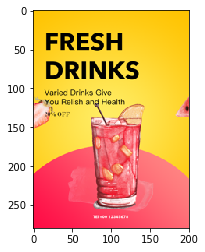

predict: [0.00110888 0.00096884 0.03986556 0.36048105 0.59757566] label [0. 0. 0. 0. 1.]


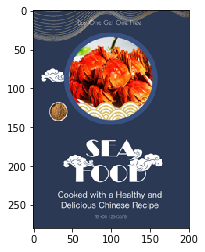

predict: [0.23769182 0.30821866 0.28129467 0.1634704  0.00932445] label [0. 0. 1. 0. 0.]


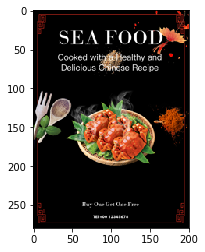

predict: [0.10664992 0.15636925 0.46885964 0.26586542 0.00225587] label [0. 0. 1. 0. 0.]


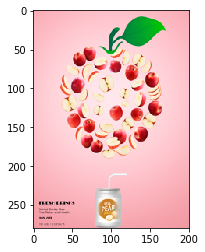

predict: [5.7764857e-05 4.2627088e-04 3.4752227e-02 9.4052327e-01 2.4240490e-02] label [0. 0. 0. 1. 0.]


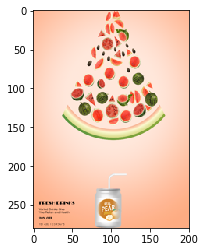

predict: [2.0781670e-04 9.9253072e-04 8.2678169e-02 7.4635512e-01 1.6976638e-01] label [0. 0. 0. 1. 0.]


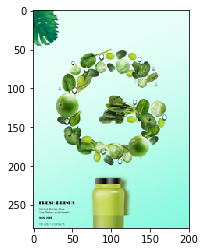

predict: [0.0151897  0.08033065 0.24307953 0.29170638 0.3696937 ] label [0. 0. 0. 1. 0.]


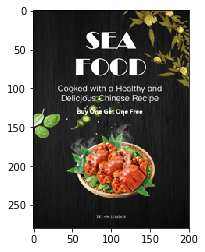

predict: [0.23062322 0.3011302  0.34261677 0.1171996  0.00843021] label [0. 0. 1. 0. 0.]


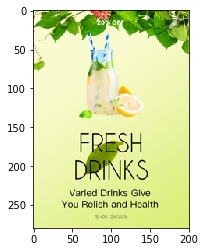

predict: [0.00100518 0.00783163 0.10658628 0.6822748  0.2023021 ] label [0. 0. 0. 1. 0.]


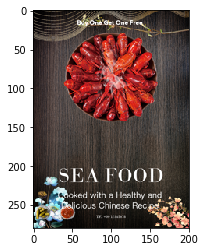

predict: [0.26075363 0.54520726 0.15388756 0.03877112 0.00138042] label [1. 0. 0. 0. 0.]


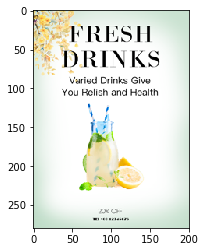

predict: [4.0447860e-04 2.2700587e-03 7.6696038e-02 6.5293235e-01 2.6769713e-01] label [0. 0. 0. 1. 0.]


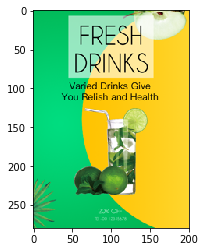

predict: [0.00293563 0.00136839 0.07675882 0.78541195 0.13352521] label [0. 0. 0. 1. 0.]


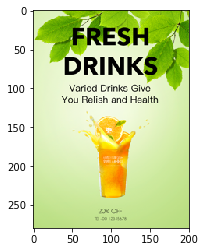

predict: [4.7044134e-05 3.4987464e-04 1.6728533e-02 2.5751245e-01 7.2536206e-01] label [0. 0. 0. 0. 1.]


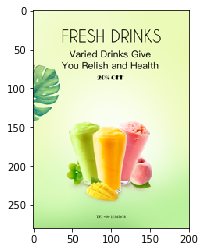

predict: [8.7359922e-06 2.3166805e-04 1.6020536e-02 1.5320569e-01 8.3053339e-01] label [0. 0. 0. 0. 1.]


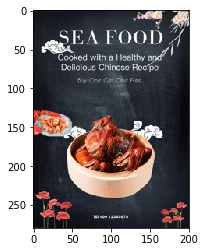

predict: [0.33244562 0.4050969  0.23937881 0.02254696 0.00053169] label [1. 0. 0. 0. 0.]


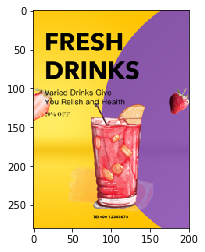

predict: [0.02002937 0.00974666 0.1100035  0.44043532 0.4197851 ] label [0. 0. 1. 0. 0.]


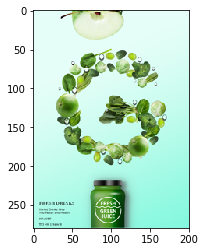

predict: [0.10472888 0.23598713 0.4014112  0.1987334  0.05913945] label [0. 0. 1. 0. 0.]


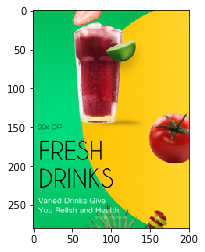

predict: [0.14929263 0.1858913  0.3416268  0.30116862 0.02202059] label [0. 1. 0. 0. 0.]


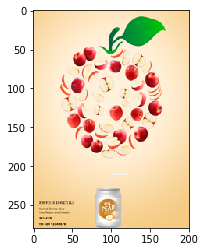

predict: [7.2140094e-05 4.4578593e-04 4.0064152e-02 9.3779552e-01 2.1622431e-02] label [0. 0. 0. 1. 0.]


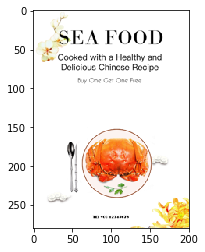

predict: [1.0980999e-05 8.0911574e-05 6.4365217e-03 4.2170319e-01 5.7176846e-01] label [0. 0. 0. 0. 1.]


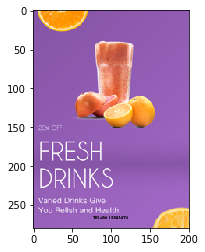

predict: [0.0033331  0.03645814 0.14886388 0.35869548 0.45264944] label [0. 0. 0. 0. 1.]


In [20]:
predict = model.predict(X_test)
print(predict)

for i in range(20, 40):
    plt.imshow(X_test[i])
    plt.show()
    print("predict:",predict[i], "label", Y_test_one_hot[i])
#     print("predict:", predict[i], "label", Y_test[i])

# for i in range(220, 240):
#     plt.imshow(X_test[i])
#     plt.show()
#     print("predict:",predict[i][0], "label", Y_test[i][0])

In [54]:
# top1
test_f1s_top1 = []
test_recalls_top1 = []
test_precisions_top1 = []

# top2
test_f1s_top2 = []
test_recalls_top2 = []
test_precisions_top2 = []

# top3
test_f1s_top3 = []
test_recalls_top3 = []
test_precisions_top3 = []

test_predict = model.predict(X_test)
        
# top1-test
test_confusion_matrix = np.zeros((5, 5))
        
for i in range(num_test):
    pre = np.argmax(test_predict[i])
    test_confusion_matrix[int(Y_test[i][0]), int(pre)] += 1

print(test_confusion_matrix)
    
test_cm_col = np.sum(test_confusion_matrix, axis=0)
test_cm_row = np.sum(test_confusion_matrix, axis=1)
        
trt1 = np.zeros(5)
tpt1 = np.zeros(5)
tft1 = np.zeros(5)
        
for i in range(5):
    trt1[i] = test_confusion_matrix[i, i] / test_cm_row[i]
    tpt1[i] = test_confusion_matrix[i, i] / test_cm_col[i]
    tft1[i] = 2 * (trt1[i] * tpt1[i]) / (trt1[i] + tpt1[i])
        
test_recalls_top1.append(trt1)
test_precisions_top1.append(tpt1)
test_f1s_top1.append(tft1)
    
# top2-test
test_confusion_matrix = np.zeros((5, 5))
        
for i in range(num_test):
    max1 = 0
    max2 = 0
    num1 = 0
    num2 = 0
    for j in range(5):
        if test_predict[i][j] > max1:
            max2 = max1
            num2 = num1
            max1 = test_predict[i][j]
            num1 = j
        elif test_predict[i][j] > max2:
            max2 = test_predict[i][j]
            num2 = j
            
    test_confusion_matrix[int(Y_test[i][0]), int(num1)] += 1
    test_confusion_matrix[int(Y_test[i][0]), int(num2)] += 1
        
test_cm_col = np.sum(test_confusion_matrix, axis=0)
test_cm_row = np.sum(test_confusion_matrix, axis=1)
        
trt2 = np.zeros(5)
tpt2 = np.zeros(5)
tft2 = np.zeros(5)
        
for i in range(5):
    trt2[i] = test_confusion_matrix[i, i] / test_cm_row[i]
    tpt2[i] = test_confusion_matrix[i, i] / test_cm_col[i]
    tft2[i] = 2 * (trt2[i] * tpt2[i]) / (trt2[i] + tpt2[i])
        
test_recalls_top2.append(trt2)
test_precisions_top2.append(tpt2)
test_f1s_top2.append(tft2)

# top3-test
test_confusion_matrix = np.zeros((5, 5))

for i in range(num_test):
    max1 = 0
    max2 = 0
    max3 = 0
    num1 = 0
    num2 = 0
    num3 = 0
    for j in range(5):
        if test_predict[i][j] > max1:
            max3 = max2
            num3 = num2
            max2 = max1
            num2 = num1
            max1 = test_predict[i][j]
            num1 = j
        elif test_predict[i][j] > max2:
            max3 = max2
            num3 = num2
            max2 = test_predict[i][j]
            num2 = j
        elif test_predict[i][j] > max3:
            max3 = test_predict[i][j]
            num3 = j
            
        test_confusion_matrix[int(Y_test[i][0]), int(num1)] += 1
        test_confusion_matrix[int(Y_test[i][0]), int(num2)] += 1
        test_confusion_matrix[int(Y_test[i][0]), int(num3)] += 1
        
print(test_confusion_matrix)
        
test_cm_col = np.sum(test_confusion_matrix, axis=0)
test_cm_row = np.sum(test_confusion_matrix, axis=1)


        
trt3 = np.zeros(5)
tpt3 = np.zeros(5)
tft3 = np.zeros(5)
        
for i in range(5):
    trt3[i] = test_confusion_matrix[i, i] / test_cm_row[i]
    tpt3[i] = test_confusion_matrix[i, i] / test_cm_col[i]
    tft3[i] = 2 * (trt3[i] * tpt3[i]) / (trt3[i] + tpt3[i])
        
test_recalls_top3.append(trt3)
test_precisions_top3.append(tpt3)
test_f1s_top3.append(tft3)

print(test_f1s_top1[-1])
print(test_recalls_top1[-1])
print(test_precisions_top1[-1])

print(test_f1s_top2[-1])
print(test_recalls_top2[-1])
print(test_precisions_top2[-1])

print(test_f1s_top3[-1])
print(test_recalls_top3[-1])
print(test_precisions_top3[-1])

[[ 0.  7.  2.  1.  0.]
 [ 0.  8. 13.  2.  0.]
 [ 0.  3. 16.  9.  2.]
 [ 0.  0.  7. 26. 17.]
 [ 0.  0.  2.  2. 33.]]
[[ 78.  39.  30.   2.   1.]
 [162.  90.  69.  22.   2.]
 [194. 111.  90.  46.   9.]
 [302. 159. 150.  98.  41.]
 [222. 112. 111.  74.  36.]]
[       nan 0.3902439  0.45714286 0.57777778 0.74157303]
[0.         0.34782609 0.53333333 0.52       0.89189189]
[       nan 0.44444444 0.4        0.65       0.63461538]
[0.20689655 0.43678161 0.39694656 0.4368932  0.47619048]
[0.15       0.41304348 0.43333333 0.45       0.47297297]
[0.33333333 0.46341463 0.36619718 0.4245283  0.47945205]
[0.14079422 0.21028037 0.2        0.19758065 0.11180124]
[0.52       0.26086957 0.2        0.13066667 0.06486486]
[0.08141962 0.17612524 0.2        0.40495868 0.40449438]


/home/wangh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


In [36]:
print(predict.shape)
num_acc = 0
for i in range(num_test):
    if predict[i][0] >= Y_test[i] - 0.1 and predict[i][0] <= Y_test[i] + 0.1:
        num_acc += 1

print(num_acc / num_test)

(100, 1)
0.48


In [21]:
print(predict.shape)
num_acc = 0
for i in range(num_test):
    max1 = 0
    max2 = 0
    num1 = 0
    num2 = 0
    for j in range(5):
        if predict[i][j] > max1:
            max2 = max1
            num2 = num1
            max1 = predict[i][j]
            num1 = j
        elif predict[i][j] > max2:
            max2 = predict[i][j]
            num2 = j
    j_test = np.argmax(Y_test_one_hot[i])
    print("top2: ", num1, num2, "label: ", j_test)
    if num1 == j_test or num2 == j_test:
        num_acc += 1

print(num_acc / num_test)

(150, 5)
top2:  3 4 label:  4
top2:  4 2 label:  4
top2:  3 2 label:  3
top2:  3 4 label:  4
top2:  3 2 label:  3
top2:  4 3 label:  4
top2:  3 2 label:  2
top2:  3 2 label:  3
top2:  4 3 label:  4
top2:  1 0 label:  0
top2:  2 3 label:  2
top2:  3 2 label:  3
top2:  3 2 label:  3
top2:  2 3 label:  2
top2:  3 2 label:  1
top2:  4 3 label:  3
top2:  2 4 label:  2
top2:  4 3 label:  4
top2:  4 3 label:  4
top2:  4 3 label:  3
top2:  4 3 label:  4
top2:  1 2 label:  2
top2:  2 3 label:  2
top2:  3 2 label:  3
top2:  3 4 label:  3
top2:  4 3 label:  3
top2:  2 1 label:  2
top2:  3 4 label:  3
top2:  1 0 label:  0
top2:  3 4 label:  3
top2:  3 4 label:  3
top2:  4 3 label:  4
top2:  4 3 label:  4
top2:  1 0 label:  0
top2:  3 4 label:  2
top2:  2 1 label:  2
top2:  2 3 label:  1
top2:  3 2 label:  3
top2:  4 3 label:  4
top2:  4 3 label:  4
top2:  2 3 label:  0
top2:  2 1 label:  2
top2:  4 3 label:  3
top2:  3 2 label:  2
top2:  4 3 label:  4
top2:  2 3 label:  3
top2:  3 4 label:  3
top2

In [22]:
model.save('model_5class_2.h5')

In [ ]:
import matplotlib.pyplot as plt
def trainVisualization(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']

    # make a figure
    fig = plt.figure(figsize=(8,4))

    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.scatter(history.epoch, history.history['loss'], marker='*')
    ax1.scatter(history.epoch, history.history['val_loss'], marker='*')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend(loc='upper right')

    # subplot acc
    ax2 = fig.add_subplot(122)
    ax2.plot(acc,label='train_acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.scatter(history.epoch, history.history['acc'], marker='*')
    ax2.scatter(history.epoch, history.history['val_acc'])
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy  on Training and Validation Data')
    ax1.legend(loc='lower right')

trainVisualization(history)

### K折验证

In [11]:
# 在卷积基上添加一个密集链接分类器
from keras import models
from keras import layers
from keras import regularizers
from keras import metrics

def top_1_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=1)

def top_2_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)


def build_model():
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    # model.add(layers.Dense(1,activation='sigmoid'))
    # modification
    model.add(layers.Dense(5, activation='softmax'))
    conv_base.trainable = False
    model.compile(optimizer='Adam',
                  # loss='binary_crossentropy',
                  # modification
                  loss='categorical_crossentropy',
                  # loss='mse')
                  metrics=[top_1_accuracy, top_2_accuracy, top_3_accuracy])
    return model
    

In [13]:
import numpy as np

Y_one_hot = to_categorical(Y)

k = 5
num_val_samples = len(X) // k
num_epochs = 10
all_val = []

for i in range(k):
    print('procseeing fold #', i)
    val_data = X[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = Y_one_hot[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [X[:i * num_val_samples],
         X[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [Y_one_hot[:i * num_val_samples],
         Y_one_hot[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data,
              partial_train_targets,
              epochs=num_epochs,
              batch_size=70)
    val_eva = model.evaluate(val_data, val_targets)
    all_val.append(val_eva)

procseeing fold # 0
Epoch 1/10
2582/2582 [==============================] - 55s 21ms/step - loss: 1.9074 - top_1_accuracy: 0.3323 - top_2_accuracy: 0.5933 - top_3_accuracy: 0.7684
Epoch 2/10
2582/2582 [==============================] - 43s 17ms/step - loss: 1.3079 - top_1_accuracy: 0.4183 - top_2_accuracy: 0.6956 - top_3_accuracy: 0.8455
Epoch 3/10
2582/2582 [==============================] - 43s 17ms/step - loss: 1.2360 - top_1_accuracy: 0.4256 - top_2_accuracy: 0.7196 - top_3_accuracy: 0.8718
Epoch 4/10
2582/2582 [==============================] - 43s 17ms/step - loss: 1.1833 - top_1_accuracy: 0.4706 - top_2_accuracy: 0.7401 - top_3_accuracy: 0.8838
Epoch 5/10
2582/2582 [==============================] - 43s 17ms/step - loss: 1.1486 - top_1_accuracy: 0.4725 - top_2_accuracy: 0.7506 - top_3_accuracy: 0.8974
Epoch 6/10
2582/2582 [==============================] - 43s 17ms/step - loss: 1.0920 - top_1_accuracy: 0.5039 - top_2_accuracy: 0.7730 - top_3_accuracy: 0.9078
Epoch 7/10
2582/2582

645/645 [==============================] - 9s 14ms/step


In [15]:
for i in all_val:
    print(i)

[1.0732221276261085, 0.516279069813647, 0.8015503876893095, 0.9426356589147287]
[1.076262938699057, 0.5565891473099243, 0.7953488373017126, 0.9333333333333333]
[1.1200669002163317, 0.513178294758464, 0.7751937984496124, 0.9069767441860465]
[1.1524925719859989, 0.48682170547256176, 0.7472868217978367, 0.9209302326505499]
[1.0689590460570284, 0.5410852714102398, 0.8186046511627907, 0.9302325581395349]
